In [1]:
%matplotlib inline
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import eli5
from sklearn.linear_model import LogisticRegressionCV

In [2]:
cats = ['alt.atheism', 'sci.space', 'sci.electronics', 'sci.med', 'rec.sport.hockey', 'rec.sport.baseball']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroups_test = fetch_20newsgroups(subset='test')
# newsgroups_train['target'] = np.array([cats[e] for e in newsgroups_train['target']])
# newsgroups_train['target'].shape[0], newsgroups_test['target'].shape[0], newsgroups_train['target'][1], newsgroups_train['data'][1]

In [3]:
estimator = SGDClassifier('log', tol=1e-3)
# estimator = CalibratedClassifierCV(estimator, cv=5)
clf = Pipeline([('vec', TfidfVectorizer(max_features=1024, ngram_range=(1,3))), ('estimator', estimator)])
clf.fit(newsgroups_train['data'], newsgroups_train['target'])

Pipeline(memory=None,
         steps=[('vec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1024,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?...
                ('estimator',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optim

In [4]:
eli5.show_weights(clf, vec=clf.named_steps['vec'], top=25, target_names=newsgroups_train.target_names)

In [5]:
eli5.show_prediction(clf, newsgroups_test['data'][0])

# LIME

In [2]:
import os
import lime
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


inet_model = inc_net.InceptionV3()

Using TensorFlow backend.


Notebook run using keras: 2.2.4
Instructions for updating:
Colocations handled automatically by placer.


('n02389026', 'sorrel', 0.25119448)
('n02437616', 'llama', 0.02425032)
('n02412080', 'ram', 0.02028681)
('n04604644', 'worm_fence', 0.019771239)
('n04049303', 'rain_barrel', 0.019236976)


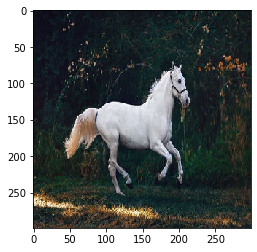

In [3]:
%load_ext autoreload
%autoreload 2

images = transform_img_fn([os.path.join('.', 'horse.jpeg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

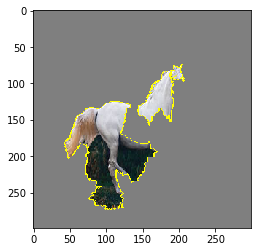

In [4]:
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))